In [ ]:
# Import necessary libraries

import torch
import pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Visualisation function

def show(tensor, channel = 1, size= (28,28), nImage = 16):
    # the input tensor for this function has the size of : batchsize x (28*28 = 784)
    data = tensor.detach().cpu().view(-1, channel, *size) # This view function will reshape the tensor to: batchSize x channel x 28 x 28
    grid = make_grid(data[:nImage], nrow = 4).permute(1,2,0)
    # We use permute to change the order of channels in the image from (1 x 28 x 28) to (28 x 28 x 1)
    plt.imshow(grid)
    plt.show

In [ ]:
# Define main hyperparameters

epochs = 100
cur_step = 0
info_step = 300 # To show the status of the generated images
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # The dimensionaly of the noise vector as input to the generator
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batchSize = 128
device = 'cuda'
dataloader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), shuffle = True, batch_size = batchSize)

# number of steps for MNIST = 60000/128 = 468.75 steps

In [ ]:
# Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)


In [ ]:
# Discriminator

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([7, 6, 7, 1, 2, 2, 2, 5, 3, 1])
torch.Size([128, 64])
torch.Size([128, 784])


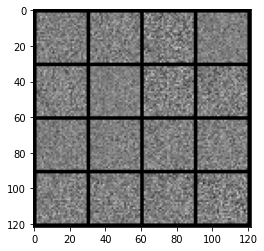

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(batchSize, z_dim)
print(noise.shape)
fake = gen(noise)
print(fake.shape)
show(fake)

In [ ]:
# Calculatin the loss

#generator loss
def calc_gen_loss(loss_func, gen, disc, number,z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)
  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach()) # To not optimize the parameters of the generator
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)


  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2
  return disc_loss

In [ ]:
# Training

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      #fake_noise = gen_noise(cur_bs, z_dim)
      #fake = gen(fake_noise)
      #show(fake)
      #show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1

  0%|          | 0/469 [00:00<?, ?it/s]

0: step 300 / Gen loss: 1.9740120758612945 / disc_loss: 0.34288733124732956


  0%|          | 0/469 [00:00<?, ?it/s]

1: step 600 / Gen loss: 3.491964357693993 / disc_loss: 0.11578140288591397
1: step 900 / Gen loss: 3.496085836887359 / disc_loss: 0.05128413207829


  0%|          | 0/469 [00:00<?, ?it/s]

2: step 1200 / Gen loss: 3.5526001731554686 / disc_loss: 0.03609291893119611


  0%|          | 0/469 [00:00<?, ?it/s]

3: step 1500 / Gen loss: 3.511511284510297 / disc_loss: 0.03565145665779713
3: step 1800 / Gen loss: 3.5311620068550083 / disc_loss: 0.03824297685176133


  0%|          | 0/469 [00:00<?, ?it/s]

4: step 2100 / Gen loss: 3.771583361625668 / disc_loss: 0.03381838358938693


  0%|          | 0/469 [00:00<?, ?it/s]

5: step 2400 / Gen loss: 4.159174847602845 / disc_loss: 0.0292494632055362
5: step 2700 / Gen loss: 4.484611890316012 / disc_loss: 0.025109530249610545


  0%|          | 0/469 [00:00<?, ?it/s]

6: step 3000 / Gen loss: 4.941389926274617 / disc_loss: 0.019261982276414832


  0%|          | 0/469 [00:00<?, ?it/s]

7: step 3300 / Gen loss: 5.21003923098246 / disc_loss: 0.02003652309377987
7: step 3600 / Gen loss: 5.430211542447408 / disc_loss: 0.019712640307843702


  0%|          | 0/469 [00:00<?, ?it/s]

8: step 3900 / Gen loss: 5.738414014180504 / disc_loss: 0.019207076486200094
8: step 4200 / Gen loss: 6.201273016929634 / disc_loss: 0.01571545296193411


  0%|          | 0/469 [00:00<?, ?it/s]

9: step 4500 / Gen loss: 6.190738471349079 / disc_loss: 0.013297696636679271


  0%|          | 0/469 [00:00<?, ?it/s]

10: step 4800 / Gen loss: 6.696181410153704 / disc_loss: 0.011155575471930199
10: step 5100 / Gen loss: 6.868257603645325 / disc_loss: 0.009995554789590336


  0%|          | 0/469 [00:00<?, ?it/s]

11: step 5400 / Gen loss: 7.01038163979848 / disc_loss: 0.010336351314714793


  0%|          | 0/469 [00:00<?, ?it/s]

12: step 5700 / Gen loss: 6.4454839817682945 / disc_loss: 0.011838313202994572
12: step 6000 / Gen loss: 6.633084214528405 / disc_loss: 0.012162022575115172


  0%|          | 0/469 [00:00<?, ?it/s]

13: step 6300 / Gen loss: 6.670359791119893 / disc_loss: 0.010128463197809955


  0%|          | 0/469 [00:00<?, ?it/s]

14: step 6600 / Gen loss: 6.899612011909481 / disc_loss: 0.008547933897158756
14: step 6900 / Gen loss: 6.814172164599095 / disc_loss: 0.008351512251344196


  0%|          | 0/469 [00:00<?, ?it/s]

15: step 7200 / Gen loss: 7.021447072029116 / disc_loss: 0.008058299773838366
15: step 7500 / Gen loss: 6.905311368306476 / disc_loss: 0.008692295839233949


  0%|          | 0/469 [00:00<?, ?it/s]

16: step 7800 / Gen loss: 6.827646994590762 / disc_loss: 0.00841165782689738


  0%|          | 0/469 [00:00<?, ?it/s]

17: step 8100 / Gen loss: 6.691477465629577 / disc_loss: 0.008780368770627925
17: step 8400 / Gen loss: 7.004444864590958 / disc_loss: 0.009717068568182486


  0%|          | 0/469 [00:00<?, ?it/s]

18: step 8700 / Gen loss: 7.234698049227391 / disc_loss: 0.009783094567246733


  0%|          | 0/469 [00:00<?, ?it/s]

19: step 9000 / Gen loss: 6.996419002215061 / disc_loss: 0.01254432811091344
19: step 9300 / Gen loss: 6.938142313957212 / disc_loss: 0.013663749127493562


  0%|          | 0/469 [00:00<?, ?it/s]

20: step 9600 / Gen loss: 6.646761797269188 / disc_loss: 0.011057387848850334


  0%|          | 0/469 [00:00<?, ?it/s]

21: step 9900 / Gen loss: 6.586285851796468 / disc_loss: 0.010150832541597385
21: step 10200 / Gen loss: 6.473693749109906 / disc_loss: 0.011333099578817691


  0%|          | 0/469 [00:00<?, ?it/s]

22: step 10500 / Gen loss: 6.789931260744733 / disc_loss: 0.01116913517316183


  0%|          | 0/469 [00:00<?, ?it/s]

23: step 10800 / Gen loss: 6.777533736228943 / disc_loss: 0.016623962370213116
23: step 11100 / Gen loss: 6.495062669118243 / disc_loss: 0.01656226383366933


  0%|          | 0/469 [00:00<?, ?it/s]

24: step 11400 / Gen loss: 6.777538865407306 / disc_loss: 0.01619973692266893
24: step 11700 / Gen loss: 6.459199498494469 / disc_loss: 0.012136943343405917


  0%|          | 0/469 [00:00<?, ?it/s]

25: step 12000 / Gen loss: 6.810702239672346 / disc_loss: 0.011742395442755267


  0%|          | 0/469 [00:00<?, ?it/s]

26: step 12300 / Gen loss: 6.849551126162213 / disc_loss: 0.01297565506072714
26: step 12600 / Gen loss: 7.001647761662799 / disc_loss: 0.013306542117691902


  0%|          | 0/469 [00:00<?, ?it/s]

27: step 12900 / Gen loss: 7.283967960675556 / disc_loss: 0.014804467280628151


  0%|          | 0/469 [00:00<?, ?it/s]

28: step 13200 / Gen loss: 6.5912351560592635 / disc_loss: 0.01870733918234084
28: step 13500 / Gen loss: 6.615653185844424 / disc_loss: 0.019590532955092707


  0%|          | 0/469 [00:00<?, ?it/s]

29: step 13800 / Gen loss: 6.076326600710544 / disc_loss: 0.019350645143228273


  0%|          | 0/469 [00:00<?, ?it/s]

30: step 14100 / Gen loss: 6.353579737345376 / disc_loss: 0.017725838640083872
30: step 14400 / Gen loss: 6.854622654914862 / disc_loss: 0.018057024445539957


  0%|          | 0/469 [00:00<?, ?it/s]

31: step 14700 / Gen loss: 6.2198450342814136 / disc_loss: 0.023870282551894592
31: step 15000 / Gen loss: 6.347924976348881 / disc_loss: 0.02122877693735065


  0%|          | 0/469 [00:00<?, ?it/s]

32: step 15300 / Gen loss: 6.4117220942179385 / disc_loss: 0.020515762773963313


  0%|          | 0/469 [00:00<?, ?it/s]

33: step 15600 / Gen loss: 6.0134146753946895 / disc_loss: 0.021701479400508105
33: step 15900 / Gen loss: 6.4044953727722165 / disc_loss: 0.022556614023633313


  0%|          | 0/469 [00:00<?, ?it/s]

34: step 16200 / Gen loss: 6.369617581367487 / disc_loss: 0.025316466620812814


  0%|          | 0/469 [00:00<?, ?it/s]

35: step 16500 / Gen loss: 6.451196807225544 / disc_loss: 0.023847623346373435
35: step 16800 / Gen loss: 6.524956734975176 / disc_loss: 0.027635166471203176


  0%|          | 0/469 [00:00<?, ?it/s]

36: step 17100 / Gen loss: 6.278304239908852 / disc_loss: 0.031022019434409815


  0%|          | 0/469 [00:00<?, ?it/s]

37: step 17400 / Gen loss: 6.202754878997804 / disc_loss: 0.036790583096444625
37: step 17700 / Gen loss: 5.8468211555481 / disc_loss: 0.03862134593228498


  0%|          | 0/469 [00:00<?, ?it/s]

38: step 18000 / Gen loss: 5.879423659642534 / disc_loss: 0.031590874395333236


  0%|          | 0/469 [00:00<?, ?it/s]

39: step 18300 / Gen loss: 6.185930967330933 / disc_loss: 0.02584360131528228
39: step 18600 / Gen loss: 6.279275016784668 / disc_loss: 0.03369433923624456


  0%|          | 0/469 [00:00<?, ?it/s]

40: step 18900 / Gen loss: 5.948732366561887 / disc_loss: 0.03217810631884883
40: step 19200 / Gen loss: 5.966055878003437 / disc_loss: 0.033197420678722375


  0%|          | 0/469 [00:00<?, ?it/s]

41: step 19500 / Gen loss: 5.754416888554886 / disc_loss: 0.037931415854642804


  0%|          | 0/469 [00:00<?, ?it/s]

42: step 19800 / Gen loss: 5.786085462570189 / disc_loss: 0.03894192847112815
42: step 20100 / Gen loss: 5.768129466374717 / disc_loss: 0.03856507591127109


  0%|          | 0/469 [00:00<?, ?it/s]

43: step 20400 / Gen loss: 5.660424200693771 / disc_loss: 0.03977078018089135


  0%|          | 0/469 [00:00<?, ?it/s]

44: step 20700 / Gen loss: 5.78697170257568 / disc_loss: 0.040880627411728127
44: step 21000 / Gen loss: 6.0653259722391795 / disc_loss: 0.04009209564266106


  0%|          | 0/469 [00:00<?, ?it/s]

45: step 21300 / Gen loss: 5.810586679776511 / disc_loss: 0.04497789584876352


  0%|          | 0/469 [00:00<?, ?it/s]

46: step 21600 / Gen loss: 5.4466053628921465 / disc_loss: 0.04577306337188926
46: step 21900 / Gen loss: 5.444782327016195 / disc_loss: 0.04548439544936022


  0%|          | 0/469 [00:00<?, ?it/s]

47: step 22200 / Gen loss: 5.290548644065858 / disc_loss: 0.04976794557956359
47: step 22500 / Gen loss: 5.75383202234904 / disc_loss: 0.056486889474714835


  0%|          | 0/469 [00:00<?, ?it/s]

48: step 22800 / Gen loss: 5.216077415148419 / disc_loss: 0.055142878054951654


  0%|          | 0/469 [00:00<?, ?it/s]

49: step 23100 / Gen loss: 5.471978507041931 / disc_loss: 0.05248567457621297
49: step 23400 / Gen loss: 5.135052800973253 / disc_loss: 0.06693264430388808


  0%|          | 0/469 [00:00<?, ?it/s]

50: step 23700 / Gen loss: 4.832029620806376 / disc_loss: 0.06626112191006538


  0%|          | 0/469 [00:00<?, ?it/s]

51: step 24000 / Gen loss: 5.104128230412799 / disc_loss: 0.06370251917901142
51: step 24300 / Gen loss: 5.0522750743230205 / disc_loss: 0.0881722254740695


  0%|          | 0/469 [00:00<?, ?it/s]

52: step 24600 / Gen loss: 4.720291295846303 / disc_loss: 0.0891526556325456


  0%|          | 0/469 [00:00<?, ?it/s]

53: step 24900 / Gen loss: 4.650239945252739 / disc_loss: 0.08319941034540532
53: step 25200 / Gen loss: 4.528205783367158 / disc_loss: 0.08092528502767284


  0%|          | 0/469 [00:00<?, ?it/s]

54: step 25500 / Gen loss: 4.705131921768188 / disc_loss: 0.07113250104089588


  0%|          | 0/469 [00:00<?, ?it/s]

55: step 25800 / Gen loss: 4.762144976456958 / disc_loss: 0.06399206893518568
55: step 26100 / Gen loss: 4.69141687552134 / disc_loss: 0.07404616773128511


  0%|          | 0/469 [00:00<?, ?it/s]

56: step 26400 / Gen loss: 4.5555112624168395 / disc_loss: 0.09053644873201852
56: step 26700 / Gen loss: 4.744046425024669 / disc_loss: 0.07782987895111244


  0%|          | 0/469 [00:00<?, ?it/s]

57: step 27000 / Gen loss: 4.4704700922966 / disc_loss: 0.0986925841619571


  0%|          | 0/469 [00:00<?, ?it/s]

58: step 27300 / Gen loss: 4.455089197953545 / disc_loss: 0.08460893662025527
58: step 27600 / Gen loss: 4.621949443817139 / disc_loss: 0.07747742919251323


  0%|          | 0/469 [00:00<?, ?it/s]

59: step 27900 / Gen loss: 4.378920813401538 / disc_loss: 0.07500295686225097


  0%|          | 0/469 [00:00<?, ?it/s]

60: step 28200 / Gen loss: 4.480845359166463 / disc_loss: 0.08498804010450835
60: step 28500 / Gen loss: 4.267417050202688 / disc_loss: 0.09115839413056771


  0%|          | 0/469 [00:00<?, ?it/s]

61: step 28800 / Gen loss: 4.324123405615491 / disc_loss: 0.09057794994364171


  0%|          | 0/469 [00:00<?, ?it/s]

62: step 29100 / Gen loss: 4.370062842369078 / disc_loss: 0.1102980696409941
62: step 29400 / Gen loss: 4.117436489264171 / disc_loss: 0.09402787884076434


  0%|          | 0/469 [00:00<?, ?it/s]

63: step 29700 / Gen loss: 4.109484178225197 / disc_loss: 0.1015260653321941
63: step 30000 / Gen loss: 3.9984000436464955 / disc_loss: 0.11907078998784221


  0%|          | 0/469 [00:00<?, ?it/s]

64: step 30300 / Gen loss: 3.8705633687972996 / disc_loss: 0.11953863044579825


  0%|          | 0/469 [00:00<?, ?it/s]

65: step 30600 / Gen loss: 3.9810556411743168 / disc_loss: 0.10955137565732018
65: step 30900 / Gen loss: 3.829976766109467 / disc_loss: 0.10822057957450554


  0%|          | 0/469 [00:00<?, ?it/s]

66: step 31200 / Gen loss: 3.744427305857341 / disc_loss: 0.12639549018194282


  0%|          | 0/469 [00:00<?, ?it/s]

67: step 31500 / Gen loss: 3.7775642220179213 / disc_loss: 0.11911345865577451
67: step 31800 / Gen loss: 3.764332315921783 / disc_loss: 0.11835848522062108


  0%|          | 0/469 [00:00<?, ?it/s]

68: step 32100 / Gen loss: 3.5996009564399714 / disc_loss: 0.1430716462433338


  0%|          | 0/469 [00:00<?, ?it/s]

69: step 32400 / Gen loss: 3.633928737640379 / disc_loss: 0.1326437145844102
69: step 32700 / Gen loss: 3.653205591042837 / disc_loss: 0.11664761163294325


  0%|          | 0/469 [00:00<?, ?it/s]

70: step 33000 / Gen loss: 3.5960720793406176 / disc_loss: 0.13074678350239993


  0%|          | 0/469 [00:00<?, ?it/s]

71: step 33300 / Gen loss: 3.564621276060741 / disc_loss: 0.12610626855244234
71: step 33600 / Gen loss: 3.669934302965803 / disc_loss: 0.11146391442666458


  0%|          | 0/469 [00:00<?, ?it/s]

72: step 33900 / Gen loss: 3.727520736058553 / disc_loss: 0.11463066843648764
72: step 34200 / Gen loss: 3.5623612626393637 / disc_loss: 0.13025706517199676


  0%|          | 0/469 [00:00<?, ?it/s]

73: step 34500 / Gen loss: 3.54552263021469 / disc_loss: 0.12312497829397523


  0%|          | 0/469 [00:00<?, ?it/s]

74: step 34800 / Gen loss: 3.514382145404816 / disc_loss: 0.14132968520124753
74: step 35100 / Gen loss: 3.4484263960520405 / disc_loss: 0.14080303651591158


  0%|          | 0/469 [00:00<?, ?it/s]

75: step 35400 / Gen loss: 3.483684453964236 / disc_loss: 0.13526225673655662


  0%|          | 0/469 [00:00<?, ?it/s]

76: step 35700 / Gen loss: 3.5521909976005555 / disc_loss: 0.1331218104064464
76: step 36000 / Gen loss: 3.48705540974935 / disc_loss: 0.1325229716921845


  0%|          | 0/469 [00:00<?, ?it/s]

77: step 36300 / Gen loss: 3.6353909738858525 / disc_loss: 0.11608178809285166


  0%|          | 0/469 [00:00<?, ?it/s]

78: step 36600 / Gen loss: 3.610665010611216 / disc_loss: 0.12817208359638846
78: step 36900 / Gen loss: 3.4147780529657994 / disc_loss: 0.1570639671136935


  0%|          | 0/469 [00:00<?, ?it/s]

79: step 37200 / Gen loss: 3.325326669216155 / disc_loss: 0.1488173264265062
79: step 37500 / Gen loss: 3.3783360830942812 / disc_loss: 0.14425307082633176


  0%|          | 0/469 [00:00<?, ?it/s]

80: step 37800 / Gen loss: 3.2990694729487138 / disc_loss: 0.15323654438058532


  0%|          | 0/469 [00:00<?, ?it/s]

81: step 38100 / Gen loss: 3.317024188836417 / disc_loss: 0.1373515348012249
81: step 38400 / Gen loss: 3.3706847810745244 / disc_loss: 0.13737812937547766


  0%|          | 0/469 [00:00<?, ?it/s]

82: step 38700 / Gen loss: 3.233566141923266 / disc_loss: 0.15515861933430025


  0%|          | 0/469 [00:00<?, ?it/s]

83: step 39000 / Gen loss: 3.325735253492992 / disc_loss: 0.13817201852798466
83: step 39300 / Gen loss: 3.5020223251978564 / disc_loss: 0.12561898599068327


  0%|          | 0/469 [00:00<?, ?it/s]

84: step 39600 / Gen loss: 3.5493303076426197 / disc_loss: 0.11948948352287211


  0%|          | 0/469 [00:00<?, ?it/s]

85: step 39900 / Gen loss: 3.4178652032216355 / disc_loss: 0.14005714468657973
85: step 40200 / Gen loss: 3.4534344244003314 / disc_loss: 0.1403995827833811


  0%|          | 0/469 [00:00<?, ?it/s]

86: step 40500 / Gen loss: 3.408698205153148 / disc_loss: 0.13872359424829483
86: step 40800 / Gen loss: 3.3738611110051466 / disc_loss: 0.14201234437525273


  0%|          | 0/469 [00:00<?, ?it/s]

87: step 41100 / Gen loss: 3.273194096088412 / disc_loss: 0.15377762660384173


  0%|          | 0/469 [00:00<?, ?it/s]

88: step 41400 / Gen loss: 3.2606476076443998 / disc_loss: 0.14532046049833314
88: step 41700 / Gen loss: 3.180467154979706 / disc_loss: 0.15680128163347637


  0%|          | 0/469 [00:00<?, ?it/s]

89: step 42000 / Gen loss: 3.2129963525136325 / disc_loss: 0.15482600697626664


  0%|          | 0/469 [00:00<?, ?it/s]

90: step 42300 / Gen loss: 3.129305352369944 / disc_loss: 0.16364131279289712
90: step 42600 / Gen loss: 3.129598902861276 / disc_loss: 0.16820161707699288


  0%|          | 0/469 [00:00<?, ?it/s]

91: step 42900 / Gen loss: 3.0241769655545574 / disc_loss: 0.1676213365793228


  0%|          | 0/469 [00:00<?, ?it/s]

92: step 43200 / Gen loss: 2.9884658765792853 / disc_loss: 0.17331065865854406
92: step 43500 / Gen loss: 3.09737138191859 / disc_loss: 0.15663416062792132


  0%|          | 0/469 [00:00<?, ?it/s]

93: step 43800 / Gen loss: 3.0609398539861044 / disc_loss: 0.1772685148566961


  0%|          | 0/469 [00:00<?, ?it/s]

94: step 44100 / Gen loss: 2.9995695137977614 / disc_loss: 0.17168872460722928
94: step 44400 / Gen loss: 3.102650398413339 / disc_loss: 0.15608182244002816


  0%|          | 0/469 [00:00<?, ?it/s]

95: step 44700 / Gen loss: 2.9703730249404914 / disc_loss: 0.1825336725016435
95: step 45000 / Gen loss: 2.8432086086273203 / disc_loss: 0.19562579321364565


  0%|          | 0/469 [00:00<?, ?it/s]

96: step 45300 / Gen loss: 3.0728204194704682 / disc_loss: 0.1591294856369495


  0%|          | 0/469 [00:00<?, ?it/s]

97: step 45600 / Gen loss: 2.996098149617514 / disc_loss: 0.1742183855921031
97: step 45900 / Gen loss: 2.9627903509140023 / disc_loss: 0.1837563477208216


  0%|          | 0/469 [00:00<?, ?it/s]

98: step 46200 / Gen loss: 2.903699007829028 / disc_loss: 0.1814122415830691


  0%|          | 0/469 [00:00<?, ?it/s]

99: step 46500 / Gen loss: 2.9625519418716424 / disc_loss: 0.17947704536219428
99: step 46800 / Gen loss: 2.9156978130340594 / disc_loss: 0.18960133736332258
